In [1]:
# For Development and debugging:
# Reload modul without restarting the kernel
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import pandas as pd
pd.options.display.max_columns = None
import os
import sys
import matplotlib.pyplot as plt
import json
import copy
import seaborn as sns
sns.set_theme(style="darkgrid")

# Add EXTERNAL_LIBS_PATH to sys paths (for loading libraries)
EXTERNAL_LIBS_PATH = '/home/hhughes/Documents/Master_Thesis/Project/workspace/libs'
sys.path.insert(1, EXTERNAL_LIBS_PATH)

# Load cortum libs
import NN_interpretability as nn_inter
import Data_augmentation as data_aug
import tfds_utils

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [3]:
# Set parameters
params = {}
params['base_path'] = '/home/hhughes/Documents/Master_Thesis/Project/workspace/Interpretability'
params['model_dirs'] = {
    'BL_RIV2_test4': '/home/hhughes/Documents/Master_Thesis/Project/workspace/Interpretability/Models/BL_RIV2_test4',}
params['CMA'] = 'CMA_0'
params['cells'] = ['258520', '208516', '262920', '307720']
params['tf_ds_name'] = 'mpp_ds_normal_dmso_z_score'
params['local_tf_datasets'] = '/data/Master_Thesis_data/datasets/tensorflow_datasets'
params['score_maps_path'] = '/data/Master_Thesis_data/datasets/Score_Maps/VarGrad_IG/BL_RIV2_test4'

plot_dir = os.path.join(params['base_path'], 'Plots')
os.makedirs(plot_dir, exist_ok=True)

## 1.1.- Load dataset

In [4]:
# Path where tf datasets are
dataset, ds_info = tfds.load(
    name=params['tf_ds_name'], 
    data_dir=params['local_tf_datasets'], 
    # If False, returns a dictionary with all the features
    as_supervised=False, 
    shuffle_files=False,
    with_info=True)

# Load TFDS metadata
tfds_metadata = tfds_utils.Costum_TFDS_metadata().load_metadata(ds_info.data_dir)
tfds_metadata.keys()

# Load splits
train_data, val_data, test_data = dataset['train'], dataset['validation'], dataset['test']

In [5]:
ds_info.splits

{'test': <tfds.core.SplitInfo num_examples=371>,
 'train': <tfds.core.SplitInfo num_examples=2962>,
 'validation': <tfds.core.SplitInfo num_examples=370>}

In [6]:
ds_info.features

FeaturesDict({
    'image': Tensor(shape=(224, 224, 38), dtype=tf.float32),
    'mapobject_id_cell': Text(shape=(), dtype=tf.string),
    'target': Tensor(shape=(1,), dtype=tf.float64),
})

In [7]:
metadata_df = tfds_metadata['metadata_df']
metadata_df

mapobject_id_cell  mapobject_id plate_name well_name  well_pos_y  \
0                263042        263055    plate01       J16           0   
1                263043        263056    plate01       J16           0   
2                263044        263057    plate01       J16           0   
3                263045        263058    plate01       J16           0   
4                263047        263060    plate01       J16           0   
...                 ...           ...        ...       ...         ...   
3698             266516        266565    plate01       J12           5   
3699             266518        266567    plate01       J12           5   
3700             266519        266568    plate01       J12           5   
3701             266520        266569    plate01       J12           5   
3702             266521        266570    plate01       J12           5   

      well_pos_x  tpoint  zplane  label  is_border plate_name_cell  \
0              0       0       0      4          0         plate01   
1              0       0       0      5          0         plate01   
2              0       0       0      6          0         plate01   
3              0       0       0      7          0         plate01   
4              0       0       0      9          0         plate01   
...          ...     ...     ...    ...        ...             ...   
3698           4       0       0     44          0         plate01   
3699           4       0       0     46          0         plate01   
3700           4       0       0     47          0         plate01   
3701           4       0       0     48          0         plate01   
3702           4       0       0     49          0         plate01   

     well_name_cell  well_pos_y_cell  well_pos_x_cell  tpoint_cell  \
0               J16                0                0            0   
1               J16                0                0            0   
2               J16                0                0            0   
3               J16                0                0            0   
4               J16                0                0            0   
...             ...              ...              ...          ...   
3698            J12                5                4            0   
3699            J12                5                4            0   
3700            J12                5                4            0   
3701            J12                5                4            0   
3702            J12                5                4            0   

      zplane_cell  label_cell  is_border_cell  is_mitotic  is_mitotic_labels  \
0               0           4               0         0.0                NaN   
1               0           5               0         0.0                NaN   
2               0           6               0         0.0                NaN   
3               0           7               0         0.0                NaN   
4               0           9               0         0.0                NaN   
...           ...         ...             ...         ...                ...   
3698            0          44               0         0.0                NaN   
3699            0          46               0         0.0                NaN   
3700            0          47               0         0.0                NaN   
3701            0          48               0         0.0                NaN   
3702            0          49               0         0.0                NaN   

      is_polynuclei_HeLa  is_polynuclei_HeLa_labels  is_polynuclei_184A1  \
0                    0.0                        NaN                  0.0   
1                    0.0                        NaN                  0.0   
2                    0.0                        NaN                  0.0   
3                    0.0                        NaN                  0.0   
4                    0.0                        NaN                  0.0   
...               

In [8]:
temp = metadata_df.copy()
temp.shape[0]

3703

In [9]:
temp['set'].value_counts()

train    2962
test      371
val       370
Name: set, dtype: int64

In [10]:
temp['set'].value_counts().values / temp.shape[0]

array([0.79989198, 0.10018904, 0.09991898])

In [11]:
temp = tfds_metadata['metadata_df'].copy()
counts = temp['perturbation'].value_counts()
print(counts)
(100 * counts.values / temp.shape[0]).round(2)

normal    2557
DMSO      1146
Name: perturbation, dtype: int64


array([69.05, 30.95])

In [12]:
temp = tfds_metadata['metadata_df'].copy()
mask = (temp['set'] == 'train')
counts = temp[mask]['perturbation'].value_counts()
print(counts)
(100 * counts.values / mask.sum()).round(2)

normal    2040
DMSO       922
Name: perturbation, dtype: int64


array([68.87, 31.13])

In [13]:
temp = tfds_metadata['metadata_df'].copy()
mask = (temp['set'] == 'val')
counts = temp[mask]['perturbation'].value_counts()
print(counts)
(100 * counts.values / mask.sum()).round(2)

normal    257
DMSO      113
Name: perturbation, dtype: int64


array([69.46, 30.54])

In [14]:
temp = tfds_metadata['metadata_df'].copy()
mask = (temp['set'] == 'test')
counts = temp[mask]['perturbation'].value_counts()
print(counts)
(100 * counts.values / mask.sum()).round(2)

normal    260
DMSO      111
Name: perturbation, dtype: int64


array([70.08, 29.92])

In [15]:
temp = tfds_metadata['metadata_df'].copy()
counts = temp['cell_cycle'].value_counts()
print(counts)
(100 * counts.values / temp.shape[0]).round(2)

G1    2070
S     1070
G2     563
Name: cell_cycle, dtype: int64


array([55.9, 28.9, 15.2])

In [16]:
temp = tfds_metadata['metadata_df'].copy()
mask = (temp['set'] == 'train')
counts = temp[mask]['cell_cycle'].value_counts()
print(counts)
(100 * counts.values / mask.sum()).round(2)

G1    1652
S      864
G2     446
Name: cell_cycle, dtype: int64


array([55.77, 29.17, 15.06])

In [17]:
temp = tfds_metadata['metadata_df'].copy()
mask = (temp['set'] == 'val')
counts = temp[mask]['cell_cycle'].value_counts()
print(counts)
(100 * counts.values / mask.sum()).round(2)

G1    205
S     103
G2     62
Name: cell_cycle, dtype: int64


array([55.41, 27.84, 16.76])

In [18]:
temp = tfds_metadata['metadata_df'].copy()
mask = (temp['set'] == 'test')
counts = temp[mask]['cell_cycle'].value_counts()
print(counts)
(100 * counts.values / mask.sum()).round(2)

G1    213
S     103
G2     55
Name: cell_cycle, dtype: int64


array([57.41, 27.76, 14.82])

In [19]:
cell_id = np.random.choice(metadata_df['mapobject_id_cell'].values)
params['cells'] = params['cells'] + [str(cell_id)]
params['cells']

['258520', '208516', '262920', '307720', '256518']

Opening cell: 258520, 1/5


Opening cell: 262920, 2/5


Opening cell: 208516, 3/5
Opening cell: 307720, 4/5
Opening cell: 256518, 5/5


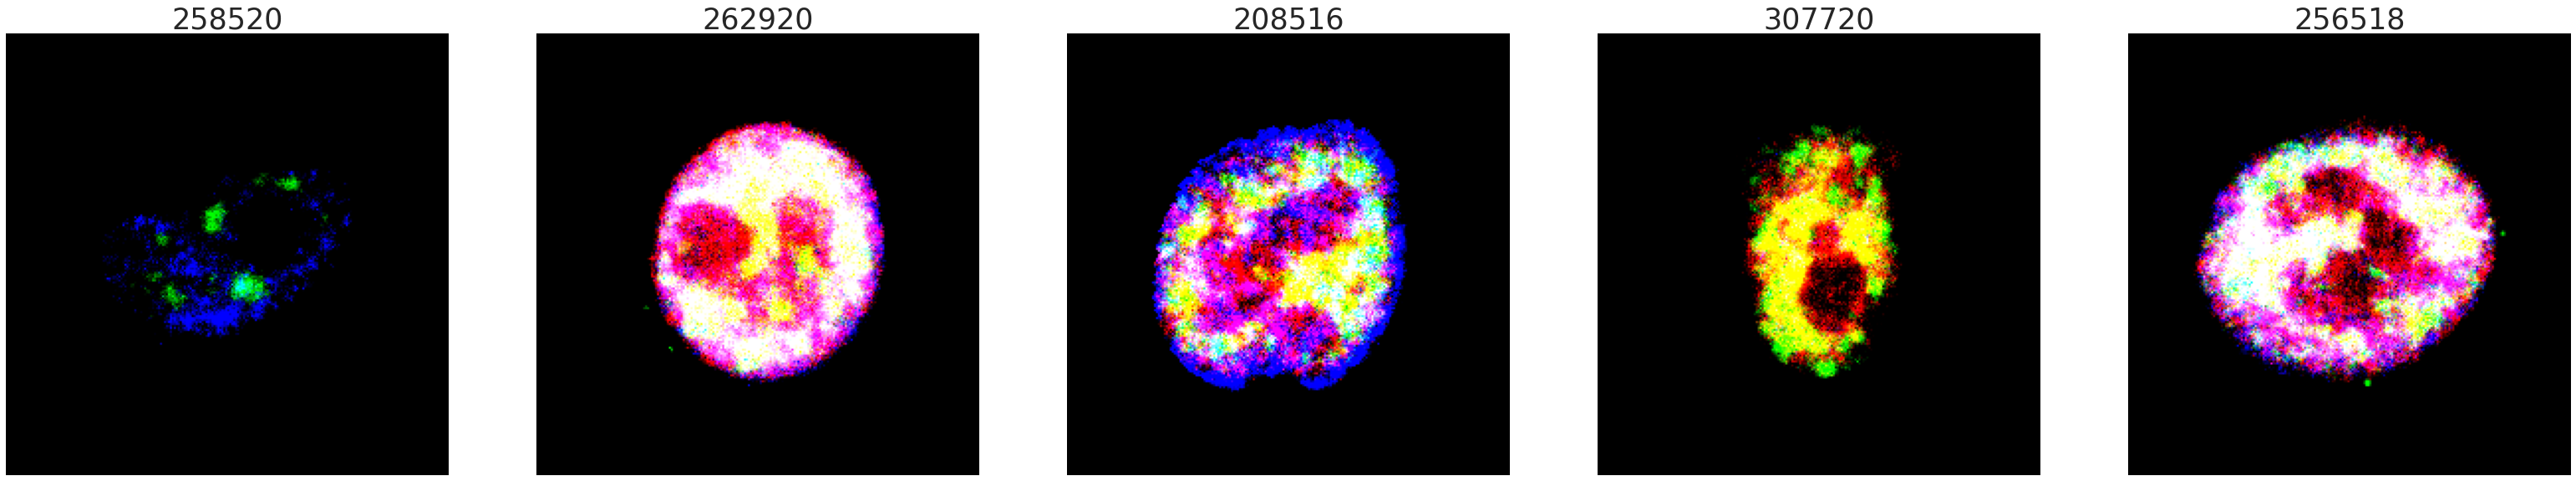

In [29]:
# Load cell, compute its Score map and save it
score_maps_dir = os.path.join(params['score_maps_path'], 'data')
#params['cells'] = big_cells
n_cells = len(params['cells'])
plt.figure(figsize=(n_cells*11,10))
dss = [train_data, val_data]
ds_names = ['train', 'val']
cell_count = 0
cells = {}
for ds, dsn in zip(dss, ds_names):
    for cell in ds:
        # get cell id
        cell_id = cell['mapobject_id_cell'].numpy()
        cell_id = str(cell_id.decode())

        if cell_id in params['cells']:
            cell_count += 1
            print('Opening cell: {}, {}/{}'.format(cell_id, cell_count, n_cells))
            
            cells[cell_id+'_img'] = cell['image'][:,:,:-1].numpy()
            cells[cell_id+'_img'] = cells[cell_id+'_img'].astype(np.float32)
            
            cells[cell_id+'_mask'] = cell['image'].numpy()
            cells[cell_id+'_mask'] = cells[cell_id+'_mask'][:,:,-1]
            cells[cell_id+'_mask'] = cells[cell_id+'_mask'].astype(np.bool)
            
            # Plot cells
            temp_img = cells[cell_id+'_img'][:,:,10:13]
            plt.subplot(1, n_cells, cell_count)

            nn_inter.plot_cell(img=temp_img, title=cell_id, title_fontsize=35)

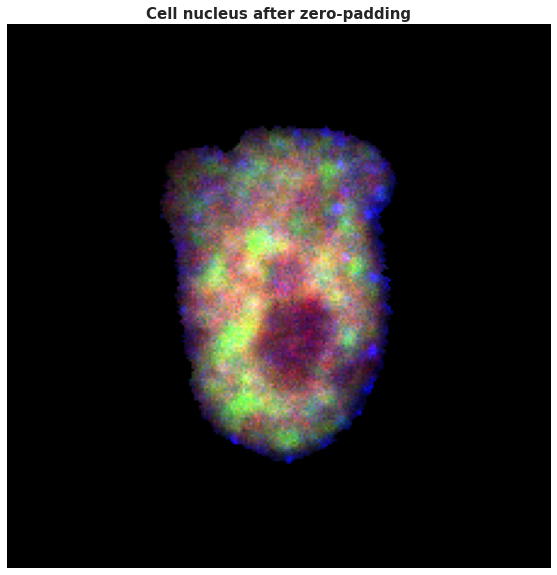

In [30]:
def plot_cell(img, cmap='PiYG', title='', vmin=0, vmax=1, colorbar=False, alpha=1, title_fontsize=15):
    fig = plt.figure(figsize=(10,10))
    plt.imshow(img,
               cmap=getattr(plt.cm, cmap),
               vmin=vmin, vmax=vmax,
               aspect='equal',
               alpha=alpha
               )
    plt.grid(False)
    plt.title(title, fontsize=title_fontsize, fontweight="bold")
    plt.axis('off')
    fig.savefig('./temp.jpg', bbox_inches='tight', pad_inches=0)

test_id = '307720'
temp_img = copy.deepcopy(cells[test_id+'_img'])
temp_mask = cells[test_id+'_mask']
min_val = temp_img[temp_mask].min(axis=0)
max_val = temp_img[temp_mask].max(axis=0)
temp_img[temp_mask] = (temp_img[temp_mask] - min_val) / (max_val - min_val)
ids = [10, 11, 15]

plot_cell(img=temp_img[:,:,ids], title='Cell nucleus after zero-padding')

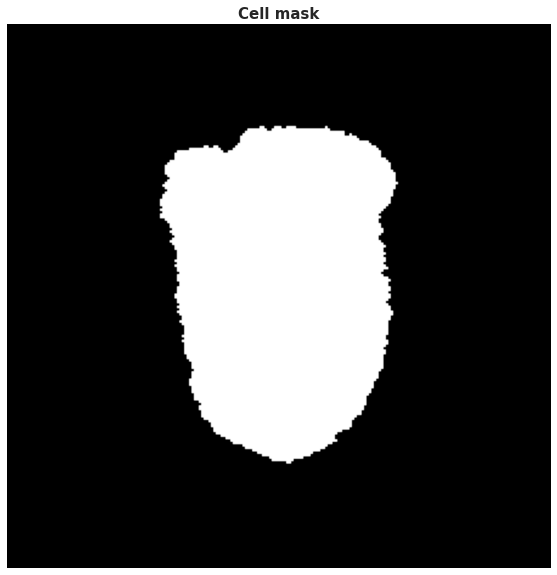

In [22]:
plot_cell(img=~temp_mask, cmap='Greys', title='Cell mask')

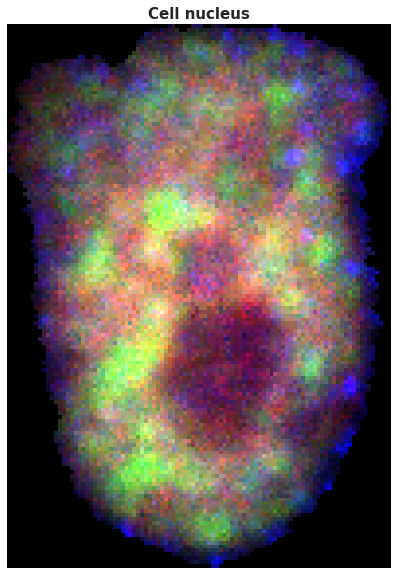

In [31]:
temp_slide = temp_img.sum(axis=2)
x_projection = (temp_slide.sum(axis=0) > 0)
x_start = np.argmax(x_projection)
x_end = 224 - np.argmax(np.flip(x_projection))

y_projection = (temp_slide.sum(axis=1) > 0)
y_start = np.argmax(y_projection)
y_end = 224 - np.argmax(np.flip(y_projection))

plot_cell(img=temp_img[y_start:y_end, x_start:x_end,ids], title='Cell nucleus')

[[27.5294216 ]
 [-0.19636274]]
[[30.46106835]
 [-0.3080748 ]]


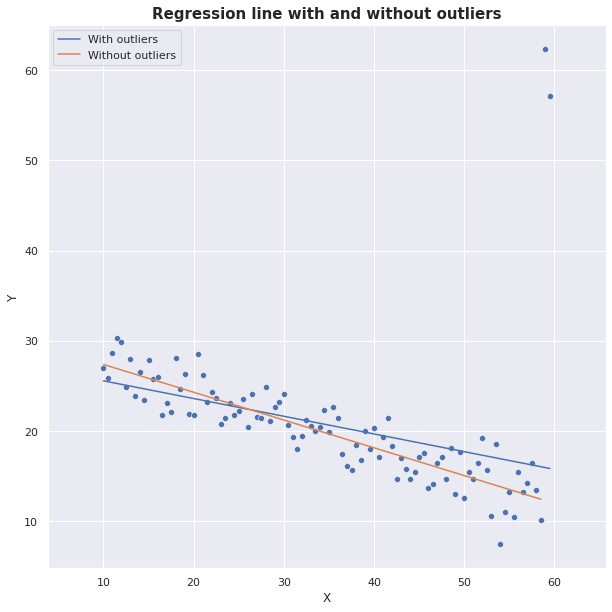

In [20]:
X = np.arange(10, 60, 0.5).reshape((-1,1))
X = np.concatenate([np.ones(X.shape), X], axis=1)
beta = np.array([[30], [-0.3]])
noise = np.random.normal(0, 2, size=100).reshape((-1,1))
noise[-1] = 45
noise[-2] = 50
Y = X @ beta + noise

b = np.linalg.inv(X.T @ X) @ (X.T @ Y)
Y_hat = X @ b
print(b)

X_new = X[0:-2,:]
Y_new = Y[0:-2]
b_2 = np.linalg.inv(X_new.T @ X_new) @ (X_new.T @ Y_new)
Y_hat_new = X_new @ b_2
print(b_2)

fig = plt.figure(figsize=(10,10))
sns.scatterplot(x=X[:,1].reshape(-1), 
                y=Y.reshape(-1))
sns.lineplot(x=X[:,1].reshape(-1), 
             y=Y_hat.reshape(-1),
             label='With outliers'
            )
sns.lineplot(x=X_new[:,1].reshape(-1), 
             y=Y_hat_new.reshape(-1),
             label='Without outliers'
            )
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Regression line with and without outliers', fontweight="bold", fontsize=15)
plt.axis('equal')
fig.savefig('./temp.jpg', bbox_inches='tight', pad_inches=0)

# Data augmentation

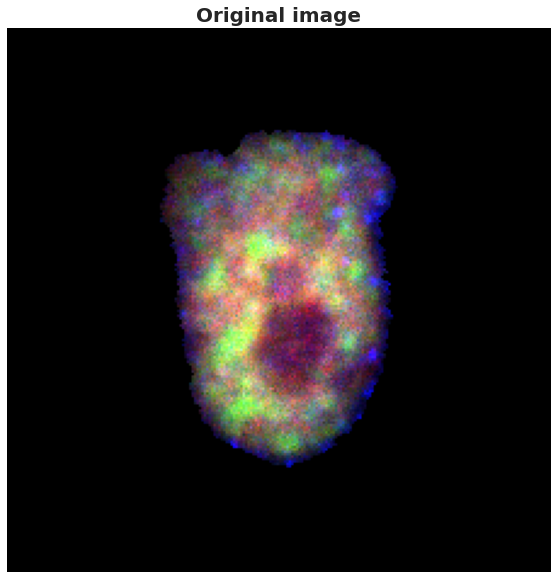

In [289]:
test_id = '307720'
temp_img = copy.deepcopy(cells[test_id+'_img'])
temp_mask = cells[test_id+'_mask']
min_val = temp_img[temp_mask].min(axis=0)
max_val = temp_img[temp_mask].max(axis=0)
temp_img[temp_mask] = (temp_img[temp_mask] - min_val) / (max_val - min_val)
ids = [10, 11, 15]

plot_cell(img=temp_img[:,:,ids], title='Original image', title_fontsize=20)

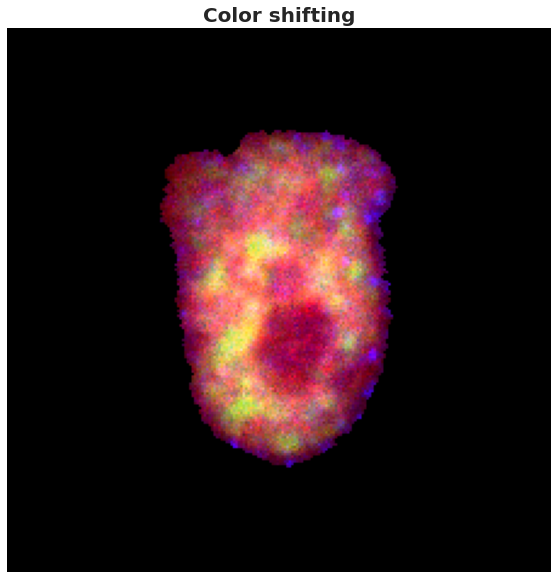

In [290]:
test_id = '307720'
temp_img = copy.deepcopy(cells[test_id+'_img'])
temp_mask = cells[test_id+'_mask']
min_val = temp_img[temp_mask].min(axis=0)
max_val = temp_img[temp_mask].max(axis=0)
temp_img[temp_mask] = (temp_img[temp_mask] - min_val) / (max_val - min_val)

temp_tensor = tf.constant(np.concatenate([temp_img, temp_mask[:,:,None]], axis=2))
temp_tensor = tf.expand_dims(temp_tensor, axis=0)

temp_tensor, _ = data_aug.apply_RandomIntencity(images=temp_tensor, targets=0, dist='uniform', mean=0, stddev=0.1)

ids = [10, 11, 15]
temp_img = temp_tensor.numpy()
temp_img = temp_img[0]
plot_cell(img=temp_img[:,:,ids], title='Color shifting', title_fontsize=20)

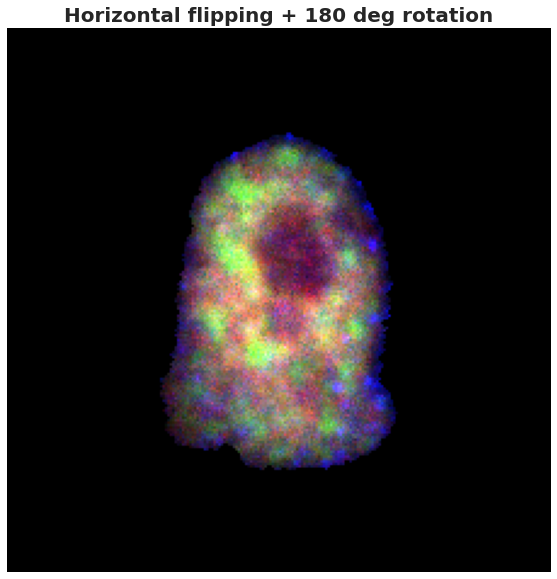

In [295]:
test_id = '307720'
temp_img = copy.deepcopy(cells[test_id+'_img'])
temp_mask = cells[test_id+'_mask']
min_val = temp_img[temp_mask].min(axis=0)
max_val = temp_img[temp_mask].max(axis=0)
temp_img[temp_mask] = (temp_img[temp_mask] - min_val) / (max_val - min_val)

temp_tensor = tf.constant(np.concatenate([temp_img, temp_mask[:,:,None]], axis=2))
temp_tensor = tf.expand_dims(temp_tensor, axis=0)

temp_tensor, _ = data_aug.apply_random_flip(temp_tensor, 0)
temp_tensor = tf.image.rot90(temp_tensor, k=2)

ids = [10, 11, 15]
temp_img = temp_tensor.numpy()
temp_img = temp_img[0]
plot_cell(img=temp_img[:,:,ids], title='Horizontal flipping + 180 deg rotation', title_fontsize=20)

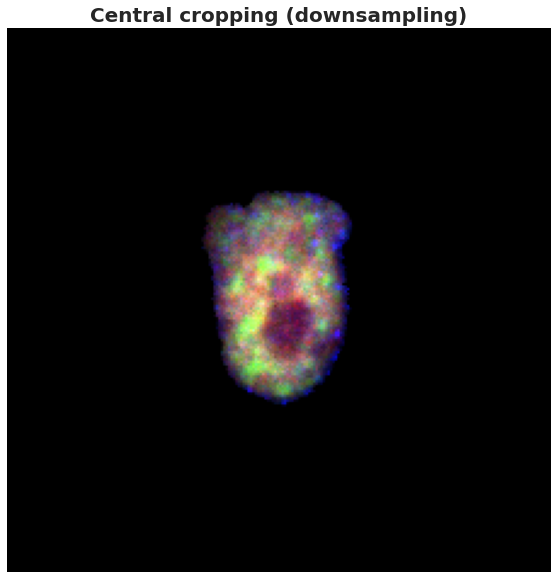

In [320]:
test_id = '307720'
temp_img = copy.deepcopy(cells[test_id+'_img'])
temp_mask = cells[test_id+'_mask']
min_val = temp_img[temp_mask].min(axis=0)
max_val = temp_img[temp_mask].max(axis=0)
temp_img[temp_mask] = (temp_img[temp_mask] - min_val) / (max_val - min_val)

temp_tensor = tf.constant(np.concatenate([temp_img, temp_mask[:,:,None]], axis=2))
temp_tensor = tf.expand_dims(temp_tensor, axis=0)

temp_tensor, _ = data_aug.apply_CenterZoom(temp_tensor, 0,
                                    mode='random_normal',
                                    mean=0.3,
                                    stddev=0.09284129451768429,
                                    lower_bound=0.1
                                    )

ids = [10, 11, 15]
temp_img = temp_tensor.numpy()
temp_img = temp_img[0]
plot_cell(img=temp_img[:,:,ids], title='Central cropping (downsampling)', title_fontsize=20)

In [396]:
mask = metadata_df.set == 'test'
ids = metadata_df[~mask].sort_values(by='cell_size_ratio').reset_index().copy()
ids = ids['mapobject_id_cell']
print(ids.shape)
print(ids[0], ids[1650], ids[3300])

(3332,)
379423 385318 372685


Opening cell: 372685, 1/3


Opening cell: 379423, 2/3


Opening cell: 385318, 3/3


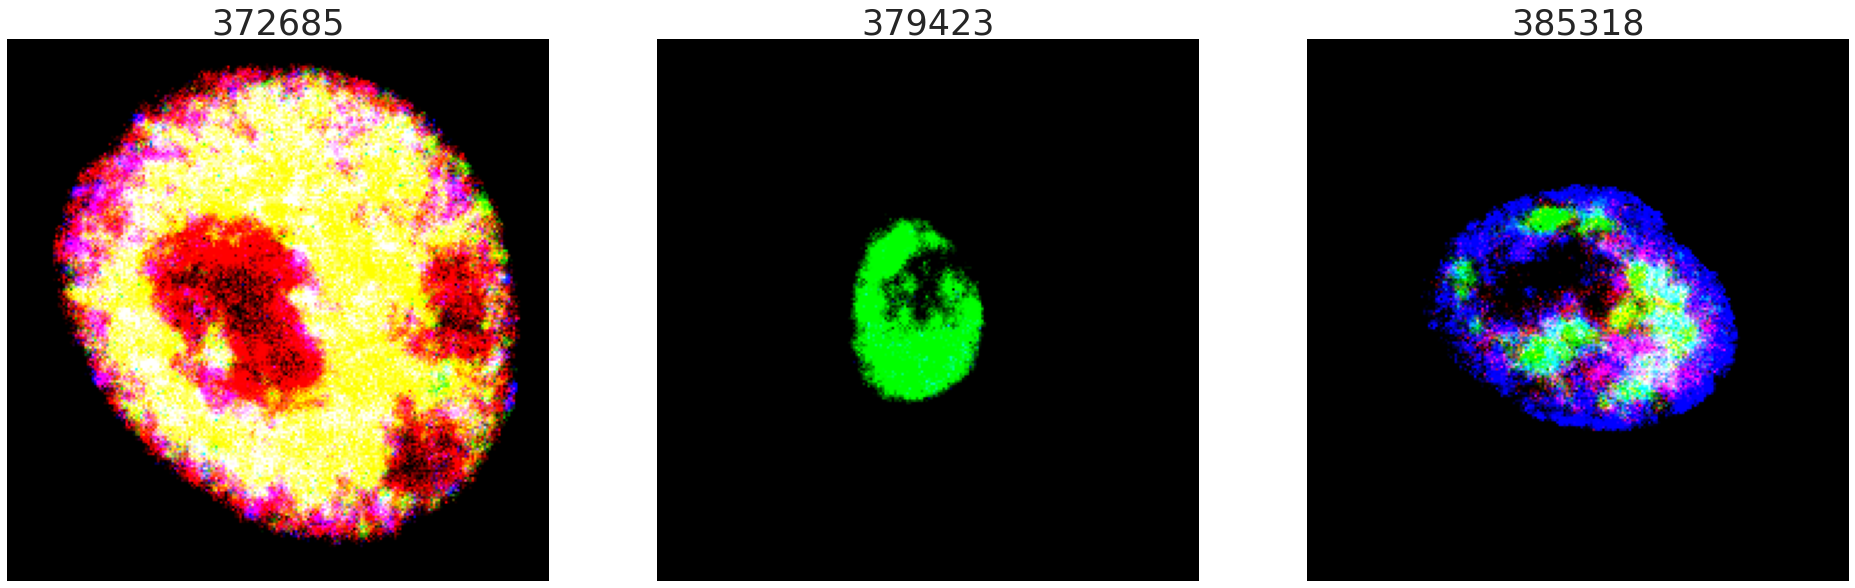

In [23]:
#metadata_df.sort_values(by='cell_size_ratio').mapobject_id_cell[1800]
cell_size_ids = ['379423', '385318', '372685']

# Load cell, compute its Score map and save it
score_maps_dir = os.path.join(params['score_maps_path'], 'data')
#params['cells'] = big_cells
n_cells = len(cell_size_ids)
plt.figure(figsize=(n_cells*11,10))
dss = [train_data, val_data]
ds_names = ['train', 'val']
cell_count = 0
cells_2 = {}
for ds, dsn in zip(dss, ds_names):
    for cell in ds:
        # get cell id
        cell_id = cell['mapobject_id_cell'].numpy()
        cell_id = str(cell_id.decode())

        if cell_id in cell_size_ids:
            cell_count += 1
            print('Opening cell: {}, {}/{}'.format(cell_id, cell_count, n_cells))
            
            cells_2[cell_id+'_img'] = cell['image'][:,:,:-1].numpy()
            cells_2[cell_id+'_img'] = cells_2[cell_id+'_img'].astype(np.float32)
            
            cells_2[cell_id+'_mask'] = cell['image'].numpy()
            cells_2[cell_id+'_mask'] = cells_2[cell_id+'_mask'][:,:,-1]
            cells_2[cell_id+'_mask'] = cells_2[cell_id+'_mask'].astype(np.bool)
            
            # Plot cells
            temp_img = cells_2[cell_id+'_img'][:,:,10:13]
            plt.subplot(1, n_cells, cell_count)

            nn_inter.plot_cell(img=temp_img, title=cell_id, title_fontsize=35)

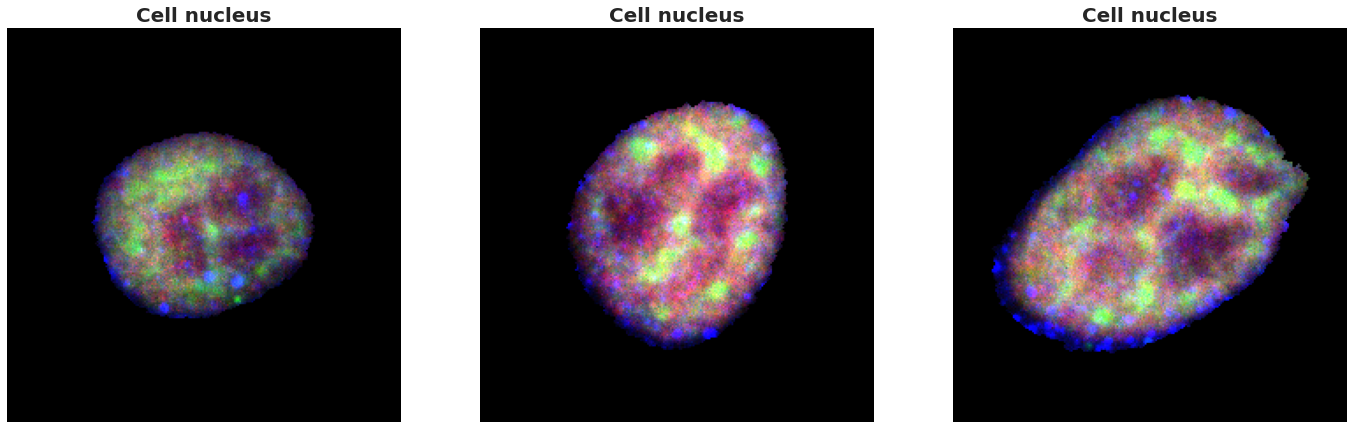

In [32]:
def plot_cell_3(img, cmap='PiYG', title='', vmin=0, vmax=1, colorbar=False, alpha=1, title_fontsize=15):
    plt.imshow(img,
               cmap=getattr(plt.cm, cmap),
               vmin=vmin, vmax=vmax,
               aspect='equal',
               alpha=alpha
               )
    plt.grid(False)
    plt.title(title, fontsize=title_fontsize, fontweight="bold")
    plt.axis('off')

ids = [10, 11, 15]

fig = plt.figure(figsize=(3*8, 8))
for i, cell_id in enumerate(cell_size_ids, 1):
    temp_img = copy.deepcopy(cells_2[cell_id+'_img'])
    temp_mask = cells_2[cell_id+'_mask']
    
    min_val = temp_img[temp_mask].min(axis=0)
    max_val = temp_img[temp_mask].max(axis=0)
    temp_img[temp_mask] = (temp_img[temp_mask] - min_val) / (max_val - min_val)
    
    plt.subplot(1, 3, i)
    plot_cell_3(img=temp_img[:,:,ids], title='Cell nucleus', title_fontsize=20)

fig.savefig('./temp.jpg', bbox_inches='tight', pad_inches=0)

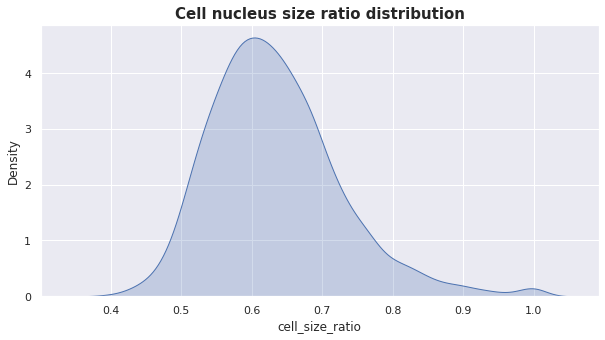

In [21]:
fig = plt.figure(figsize=(10,5))
sns.kdeplot(data=metadata_df,
            x='cell_size_ratio',
            shade=True,
            bw_method=0.2
           )
plt.title('Cell nucleus size ratio distribution', fontsize=15, fontweight="bold")
fig.savefig('./temp.jpg', bbox_inches='tight', pad_inches=0)

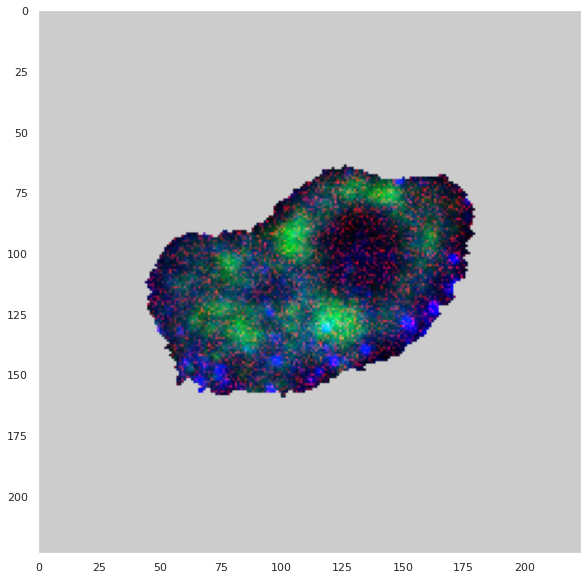

In [333]:
def plot_cell_2(img, cmap='PiYG', title='', vmin=0, vmax=1, colorbar=False, alpha=1, title_fontsize=15):
    fig = plt.figure(figsize=(10,10))
    plt.imshow(img,
               cmap=getattr(plt.cm, cmap),
               vmin=vmin, vmax=vmax,
               aspect='equal',
               alpha=alpha
               )
    plt.grid(False)
    plt.title(title, fontsize=title_fontsize, fontweight="bold")
    fig.savefig('./temp.jpg', bbox_inches='tight', pad_inches=0)

test_id = '258520'
temp_img = copy.deepcopy(cells[test_id+'_img'])
temp_mask = cells[test_id+'_mask']

temp_img[~temp_mask] = 0.8

min_val = temp_img[temp_mask].min(axis=0)
max_val = temp_img[temp_mask].max(axis=0)
temp_img[temp_mask] = (temp_img[temp_mask] - min_val) / (max_val - min_val)
ids = [10, 11, 15]

plot_cell_2(img=temp_img[:,:,ids], title='', title_fontsize=20)

In [22]:
mask = metadata_df.set != 'test'
mask &= metadata_df.cell_cycle == 'G1'
metadata_df[mask]

mask = metadata_df.set != 'test'
mask &= metadata_df.cell_cycle == 'S'
metadata_df[mask]

mask = metadata_df.set != 'test'
mask &= metadata_df.cell_cycle == 'G2'
metadata_df[mask]

mapobject_id_cell  mapobject_id plate_name well_name  well_pos_y  \
25               364213        364400    plate01       J16           0   
27               364215        364402    plate01       J16           0   
37               226855        226903    plate01       J16           0   
40               226861        226909    plate01       J16           0   
42               226864        226912    plate01       J16           0   
...                 ...           ...        ...       ...         ...   
3622             308780        308862    plate01       J12           5   
3654             210120        210146    plate01       J12           5   
3695             266511        266560    plate01       J12           5   
3698             266516        266565    plate01       J12           5   
3700             266519        266568    plate01       J12           5   

      well_pos_x  tpoint  zplane  label  is_border plate_name_cell  \
25             1       0       0     39          0         plate01   
27             1       0       0     41          0         plate01   
37             2       0       0     13          0         plate01   
40             2       0       0     19          0         plate01   
42             2       0       0     22          0         plate01   
...          ...     ...     ...    ...        ...             ...   
3622           0       0       0      7          0         plate01   
3654           2       0       0     10          0         plate01   
3695           4       0       0     39          0         plate01   
3698           4       0       0     44          0         plate01   
3700           4       0       0     47          0         plate01   

     well_name_cell  well_pos_y_cell  well_pos_x_cell  tpoint_cell  \
25              J16                0                1            0   
27              J16                0                1            0   
37              J16                0                2            0   
40              J16                0                2            0   
42              J16                0                2            0   
...             ...              ...              ...          ...   
3622            J12                5                0            0   
3654            J12                5                2            0   
3695            J12                5                4            0   
3698            J12                5                4            0   
3700            J12                5                4            0   

      zplane_cell  label_cell  is_border_cell  is_mitotic  is_mitotic_labels  \
25              0          39               0         0.0                NaN   
27              0          41               0         0.0                NaN   
37              0          13               0         0.0                NaN   
40              0          19               0         0.0                NaN   
42              0          22               0         0.0                NaN   
...           ...         ...             ...         ...                ...   
3622            0           7               0         0.0                NaN   
3654            0          10               0         0.0                NaN   
3695            0          39               0         0.0                NaN   
3698            0          44               0         0.0                NaN   
3700            0          47               0         0.0                NaN   

      is_polynuclei_HeLa  is_polynuclei_HeLa_labels  is_polynuclei_184A1  \
25                   0.0                        NaN                  0.0   
27                   0.0                        NaN                  0.0   
37                   0.0                        NaN                  0.0   
40                   0.0                        NaN                  0.0   
42                   0.0                        NaN                  0.0   
...               

Opening cell: 266508, 1/3


Opening cell: 308780, 2/3
Opening cell: 364187, 3/3


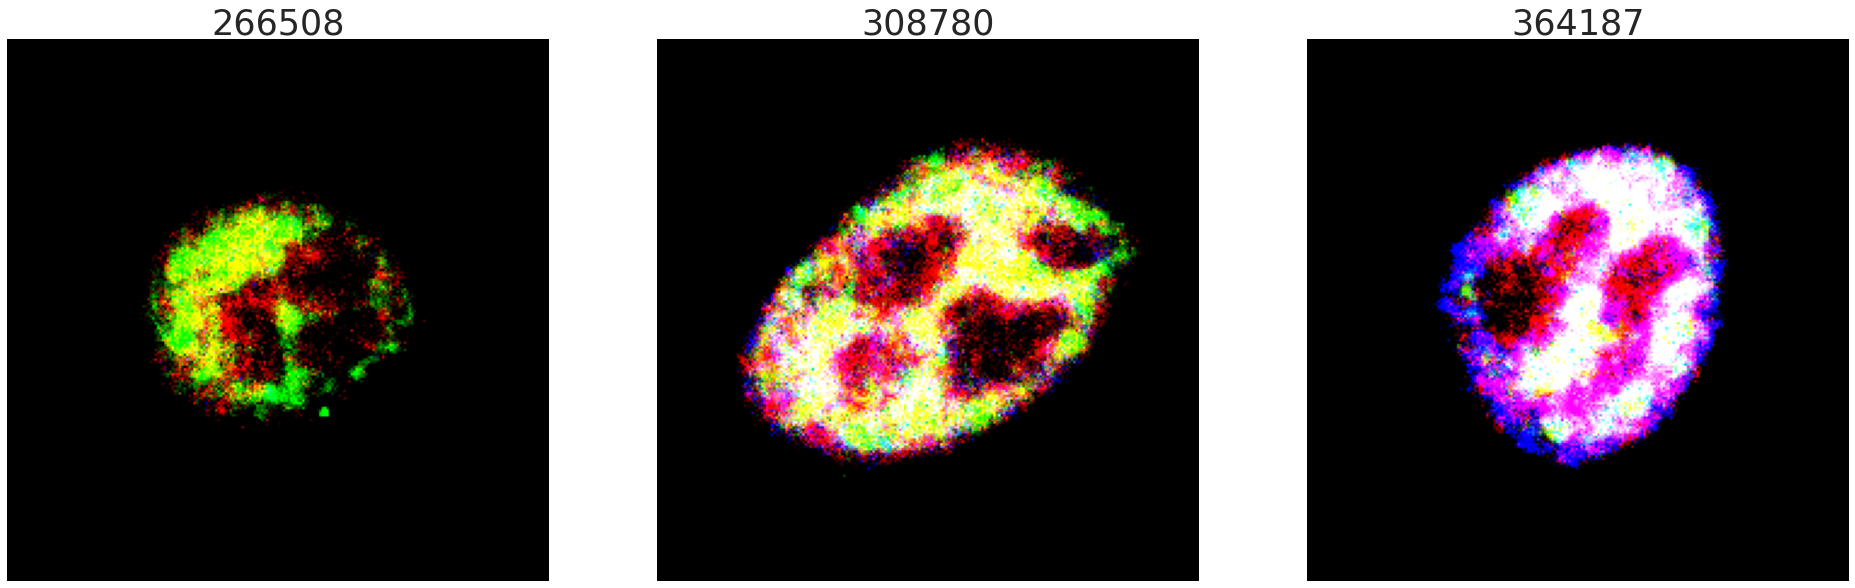

In [23]:
cell_size_ids = ['266508', '364187', '308780']

# Load cell, compute its Score map and save it
score_maps_dir = os.path.join(params['score_maps_path'], 'data')
#params['cells'] = big_cells
n_cells = len(cell_size_ids)
plt.figure(figsize=(n_cells*11,10))
dss = [train_data, val_data]
ds_names = ['train', 'val']
cell_count = 0
cells_2 = {}
for ds, dsn in zip(dss, ds_names):
    for cell in ds:
        # get cell id
        cell_id = cell['mapobject_id_cell'].numpy()
        cell_id = str(cell_id.decode())

        if cell_id in cell_size_ids:
            cell_count += 1
            print('Opening cell: {}, {}/{}'.format(cell_id, cell_count, n_cells))
            
            cells_2[cell_id+'_img'] = cell['image'][:,:,:-1].numpy()
            cells_2[cell_id+'_img'] = cells_2[cell_id+'_img'].astype(np.float32)
            
            cells_2[cell_id+'_mask'] = cell['image'].numpy()
            cells_2[cell_id+'_mask'] = cells_2[cell_id+'_mask'][:,:,-1]
            cells_2[cell_id+'_mask'] = cells_2[cell_id+'_mask'].astype(np.bool)
            
            # Plot cells
            temp_img = cells_2[cell_id+'_img'][:,:,10:13]
            plt.subplot(1, n_cells, cell_count)

            nn_inter.plot_cell(img=temp_img, title=cell_id, title_fontsize=35)
            

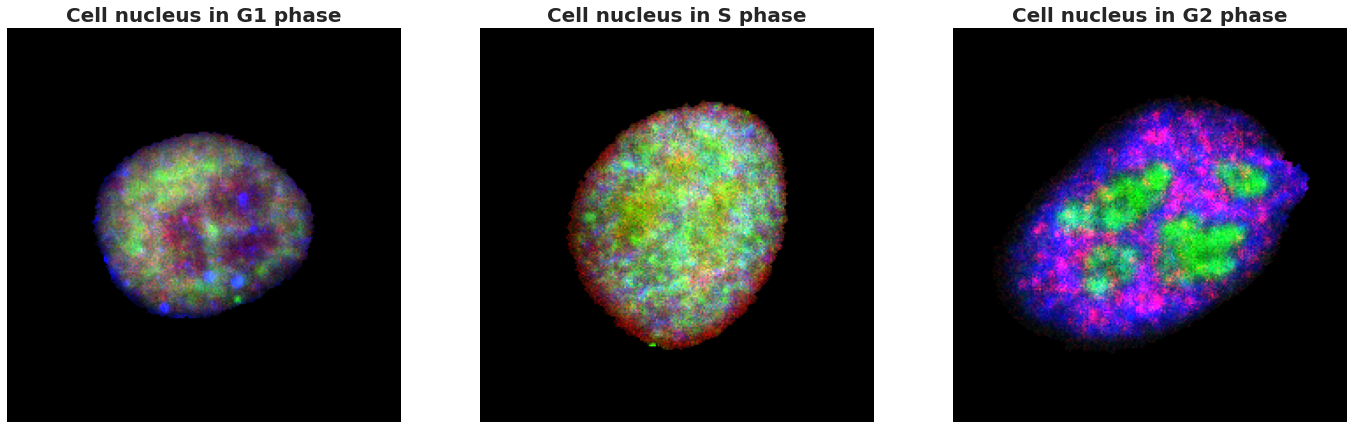

In [26]:
ids = np.array([[10, 11, 15], [0,4,8], [2,18,25]])

fig = plt.figure(figsize=(3*8, 8))
for i, cell_id in enumerate(cell_size_ids, 1):
    temp_img = copy.deepcopy(cells_2[cell_id+'_img'])
    temp_mask = cells_2[cell_id+'_mask']
    
    min_val = temp_img[temp_mask].min(axis=0)
    max_val = temp_img[temp_mask].max(axis=0)
    temp_img[temp_mask] = (temp_img[temp_mask] - min_val) / (max_val - min_val)
    
    mask = metadata_df.mapobject_id_cell == int(cell_id)
    cell_cycle = metadata_df[mask].cell_cycle.values[0]
    
    plt.subplot(1, 3, i)
    plot_cell_3(img=temp_img[:,:,ids[i-1]], title='Cell nucleus in '+cell_cycle+' phase', title_fontsize=20)

fig.savefig('./temp.jpg', bbox_inches='tight', pad_inches=0)

In [440]:
ids[0]

array([10, 11, 15])

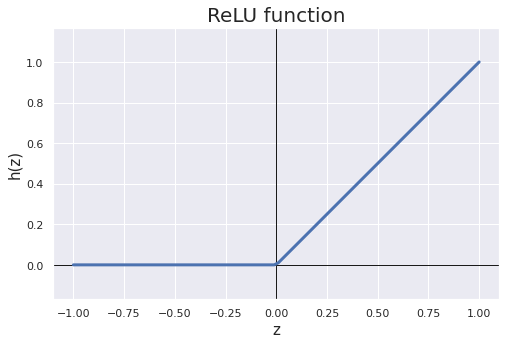

In [27]:
z = np.linspace(-1,1,100)
h_z = 1 * z * (z>0)

fig = plt.figure(figsize=(8,5))
plt.axhline(y=0, color='k', linewidth = 1)
plt.axvline(x=0, color='k', linewidth = 1)
sns.lineplot(x=z, y=h_z, linewidth=3)
plt.grid(True)
plt.axis('equal')
plt.ylabel('h(z)', fontsize=15)
plt.xlabel('z', fontsize=15)
plt.title('ReLU function', fontsize=20)
fig.savefig('./temp.jpg', bbox_inches='tight', pad_inches=0)

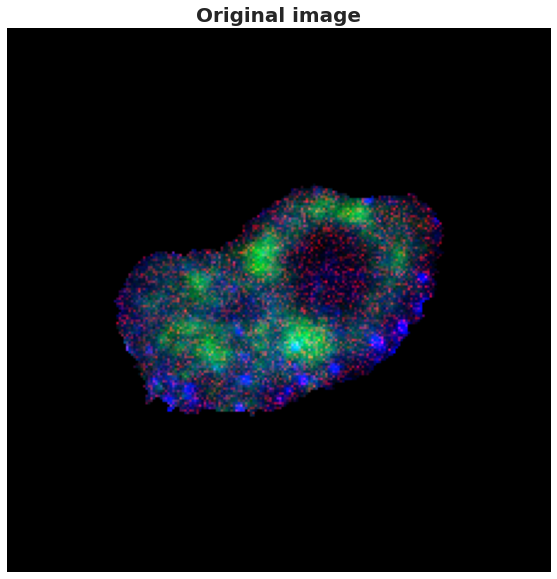

In [33]:
test_id = '258520'
temp_img = copy.deepcopy(cells[test_id+'_img'])
temp_mask = cells[test_id+'_mask']
min_val = temp_img[temp_mask].min(axis=0)
max_val = temp_img[temp_mask].max(axis=0)
temp_img[temp_mask] = (temp_img[temp_mask] - min_val) / (max_val - min_val)
ids = [10, 11, 15]

plot_cell(img=temp_img[:,:,ids], title='Original image', title_fontsize=20)

# Baseline values

In [34]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
huber_loss = tf.keras.losses.Huber()

# Load TFDS metadata
tfds_metadata = tfds_utils.Costum_TFDS_metadata().load_metadata(ds_info.data_dir)
tfds_metadata.keys()

dict_keys(['data_pp_parameters', 'channels_df', 'tfds_creation_parameters', 'metadata_df'])

In [40]:
method = 'avg'
mask = tfds_metadata['metadata_df'].set == 'train'
Y_train = tfds_metadata['metadata_df']['00_EU_'+method][mask].values
Y_train_bar = Y_train.mean()# * np.ones(Y_train.shape)

mask = tfds_metadata['metadata_df'].set == 'test'
Y_test = tfds_metadata['metadata_df']['00_EU_'+method][mask].values
Y_hat = Y_train_bar * np.ones(Y_test.shape)


MSE_BL = round(mean_squared_error(Y_test, Y_hat), 2)
MAE_BL = round(mean_absolute_error(Y_test, Y_hat), 2)
Huber_BL = str(round(huber_loss(Y_test, Y_hat).numpy(), 2))
R2_BL = round(r2_score(Y_test, Y_hat), 2)
bias = round((Y_test - Y_hat).mean(), 2)
std = round((Y_test - Y_hat).std(), 2)
print('Baseline metric values:\n\tBias: {}, Std: {}, MSE: {}, MAE: {}, Huber: {}, R2: {}'.format(bias, std, MSE_BL, MAE_BL, Huber_BL, R2_BL))

Baseline metric values:
	Bias: 4.86, Std: 59.99, MSE: 3622.74, MAE: 45.56, Huber: 45.07, R2: -0.01


In [36]:
path = '/home/hhughes/Documents/Master_Thesis/Project/workspace/Manuscript_content/Results_data/Model_metrics'
file_names = ['metrics_LM_1.csv', 'metrics_LM_2.csv', 'metrics_BL_1.csv', 'metrics_BL_2.csv', 'metrics_RN_1.csv', 'metrics_RN_2.csv', 'metrics_XC_1.csv', 'metrics_XC_2.csv']
model_name = ['Linear', 'Linear', 'Simple_CNN', 'Simple_CNN', 'ResNet50V2', 'ResNet50V2', 'Xception', 'Xception']
data_type = ['structure', 'color-structure', 'structure', 'color-structure', 'structure', 'color-structure', 'structure', 'color-structure']

# Load history
test_metrics = pd.DataFrame()
for fn, mn, dt in zip(file_names, model_name, data_type):
    with open(os.path.join(path, fn), 'r') as file:
        temp_df = pd.read_csv(file)
        #history[mn] = temp[metric]
        selected_columns = ['Bias', 'Std', 'R2', 'MAE', 'MSE', 'Huber']
        mask = temp_df.Set == 'test'
        mask &= temp_df.CMA_size == 0
        temp_df = temp_df[selected_columns][mask]
        #temp_df = temp_df[mask]
        temp_df['Model_name'] = mn
        temp_df['Data_type'] = dt
        
    test_metrics = pd.concat((test_metrics, temp_df), axis=0, ignore_index=True)
test_metrics['Bias'] = test_metrics['Bias'].abs()
test_metrics

Bias      Std      R2      MAE        MSE    Huber  Model_name  \
0  4.0356  54.1583  0.1827  40.5240  2941.5009  40.0263      Linear   
1  4.0676  46.8302  0.3877  35.2682  2203.7020  34.7712      Linear   
2  0.7783  43.9427  0.4648  33.0879  1926.3577  32.5912  Simple_CNN   
3  3.0029  41.2799  0.5253  30.6832  1708.4535  30.1893  Simple_CNN   
4  0.4579  43.3805  0.4785  31.8325  1877.0017  31.3371  ResNet50V2   
5  1.4927  42.8171  0.4914  32.7383  1830.5932  32.2425  ResNet50V2   
6  7.2306  45.5022  0.4118  33.9267  2117.1513  33.4269    Xception   
7  6.6956  41.5778  0.5085  31.6646  1768.8821  31.1670    Xception   

         Data_type  
0        structure  
1  color-structure  
2        structure  
3  color-structure  
4        structure  
5  color-structure  
6        structure  
7  color-structure

In [37]:
temp_df = test_metrics.set_index(['Model_name', 'Data_type']).stack().reset_index()
temp_df.columns = ['Model_name', 'Data_type', 'Metric', 'Value']
temp_df.head()

Model_name  Data_type Metric      Value
0     Linear  structure   Bias     4.0356
1     Linear  structure    Std    54.1583
2     Linear  structure     R2     0.1827
3     Linear  structure    MAE    40.5240
4     Linear  structure    MSE  2941.5009

In [38]:
temp_df.Metric.unique()

array(['Bias', 'Std', 'R2', 'MAE', 'MSE', 'Huber'], dtype=object)

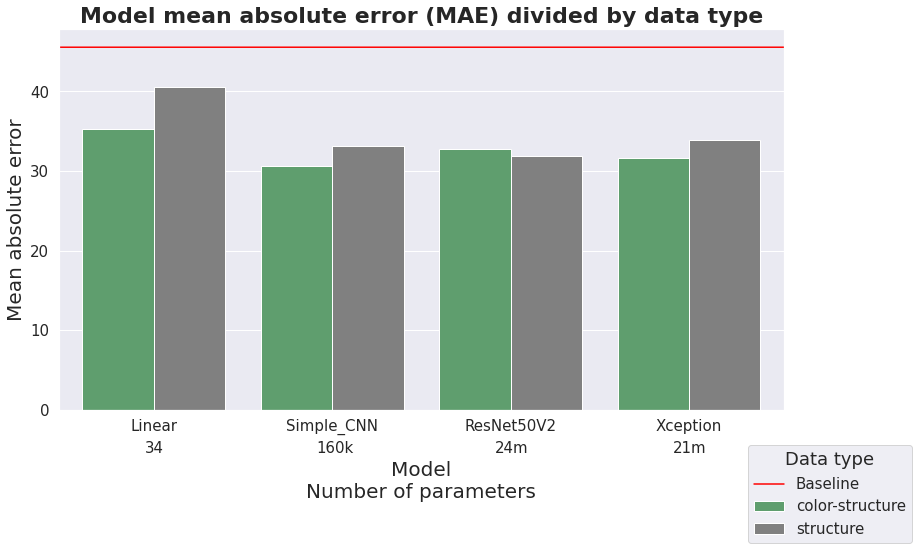

In [144]:
sns.set_style("darkgrid")

temp_df = test_metrics.set_index(['Model_name', 'Data_type']).stack().reset_index()
temp_df.columns = ['Model_name', 'Data_type', 'Metric', 'Value']
palette = {'color-structure': 'C2', 'structure': 'grey'}
mask = temp_df.Metric == 'MAE'

fig = plt.figure(figsize=(13,7))

g = sns.barplot(data=temp_df[mask],
            x='Model_name',
            y='Value',
            hue='Data_type',
            hue_order=['color-structure', 'structure'],
            palette=palette,
           )
# get x range
vals = []
for patch in g.patches:
    vals.append(patch.get_xy()[0])
bar_width = patch.get_width()
vals = np.array(vals)

x_lim = [vals.min()-bar_width/3, vals.max()+4*bar_width/3]

# Plot baseline value
x = np.arange(x_lim[0], x_lim[1], 0.001)
y = MAE_BL * np.ones(x.shape)
sns.lineplot(x=x, y=y, color='red', label='Baseline')

plt.xticks(fontsize=15)
plt.xlim(x_lim)
plt.yticks(fontsize=15)
plt.xlabel('\nModel\nNumber of parameters', fontsize=20)
plt.ylabel('Mean absolute error', fontsize=20)
#_ = plt.legend(title='Data type', loc='upper right', title_fontsize=18, fontsize=15)
_ = plt.legend(title='Data type', loc=(0.95,-0.35), title_fontsize=18, fontsize=15)
_ = plt.title('Model mean absolute error (MAE) divided by data type', fontsize=22, fontweight='bold')

# add number of parameters
n_params = ['34', '160k', '24m', '21m']
shifts = [0.05, 0.09, 0.09, 0.09]
for x, (n, s) in enumerate(zip(n_params, shifts)):
    g.text(x-s, -5.5, n, fontsize=15)

fig.savefig('./temp.png', bbox_inches='tight', pad_inches=0, transparent=True)

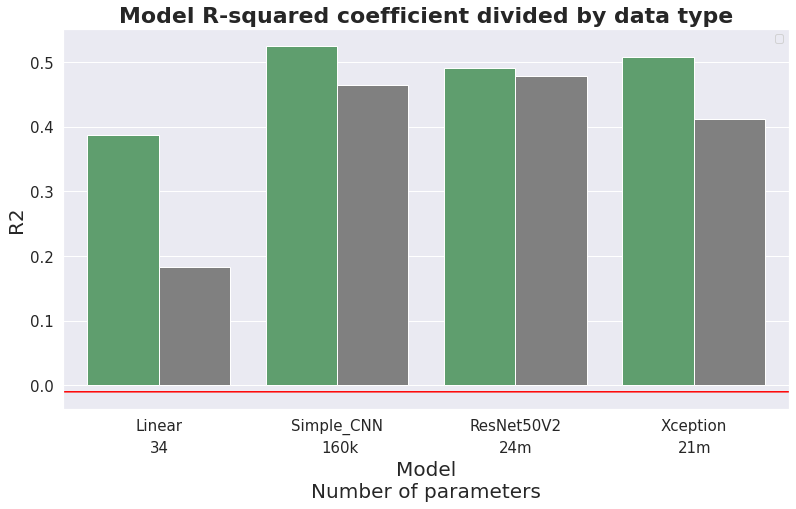

In [135]:
sns.set_style("darkgrid")

temp_df = test_metrics.set_index(['Model_name', 'Data_type']).stack().reset_index()
temp_df.columns = ['Model_name', 'Data_type', 'Metric', 'Value']
palette = {'color-structure': 'C2', 'structure': 'grey'}
mask = temp_df.Metric == 'R2'

fig = plt.figure(figsize=(13,7))

g = sns.barplot(data=temp_df[mask],
            x='Model_name',
            y='Value',
            hue='Data_type',
            hue_order=['color-structure', 'structure'],
            palette=palette,
           )
# get x range
vals = []
for patch in g.patches:
    vals.append(patch.get_xy()[0])
bar_width = patch.get_width()
vals = np.array(vals)

x_lim = [vals.min()-bar_width/3, vals.max()+4*bar_width/3]

# Plot baseline value
x = np.arange(x_lim[0], x_lim[1], 0.001)
y = R2_BL * np.ones(x.shape)
sns.lineplot(x=x, y=y, color='red', label='Baseline')

plt.xticks(fontsize=15)
plt.xlim(x_lim)
plt.yticks(fontsize=15)
plt.xlabel('\nModel\nNumber of parameters', fontsize=20)
plt.ylabel('R2', fontsize=20)
#_ = plt.legend(title='Data type', loc='upper left', title_fontsize=18, fontsize=15)
_ = plt.legend('')
_ = plt.title('Model R-squared coefficient divided by data type', fontsize=22, fontweight='bold')

# add number of parameters
n_params = ['34', '160k', '24m', '21m']
shifts = [0.05, 0.09, 0.09, 0.09]
for x, (n, s) in enumerate(zip(n_params, shifts)):
    g.text(x-s, -0.103, n, fontsize=15)
    
fig.savefig('./temp.png', bbox_inches='tight', pad_inches=0, transparent=True)

## Training plots only Spatial

In [149]:
def plot_train_metrics(history=None, metric=metric, colors=None, title='', figsize=(15,23), ylim=[25,100]):

    fig = plt.figure(figsize=figsize)
    
    # Plot baseline value
    x = np.arange(1, 801)
    y = 48.24 * np.ones(800)
    plt.plot(x, y, alpha=1, label='avg y', c='grey')

    for key, color in zip(history, colors):
            
        # Plot Train loss
        x = range(1, len(history[key])+1)
        # Plot Validation loss
        plt.plot(x, history[key], alpha=0.5, label=key, c=color)

        # Plot a red point in the epoch with the best val metric
        val_min = np.asarray(history[key]).min()
        val_min_idx = np.argmin(history[key]) + 1
        label='{}\nBets={} at Epoch={}'.format(key, round(val_min,2), val_min_idx)
        plt.scatter(x=val_min_idx, y=val_min, c=color, linewidths=4, label=label)

    plt.grid(True)
    plt.xlim([30, 300])
    plt.ylim(ylim)
    plt.xlabel('Epoch', fontsize=15)
    plt.ylabel(metric, fontsize=15)
    plt.legend(loc='upper right')
    plt.title(title, fontweight='bold', fontsize=18)
    fig.savefig('./temp.jpg', bbox_inches='tight', pad_inches=0)

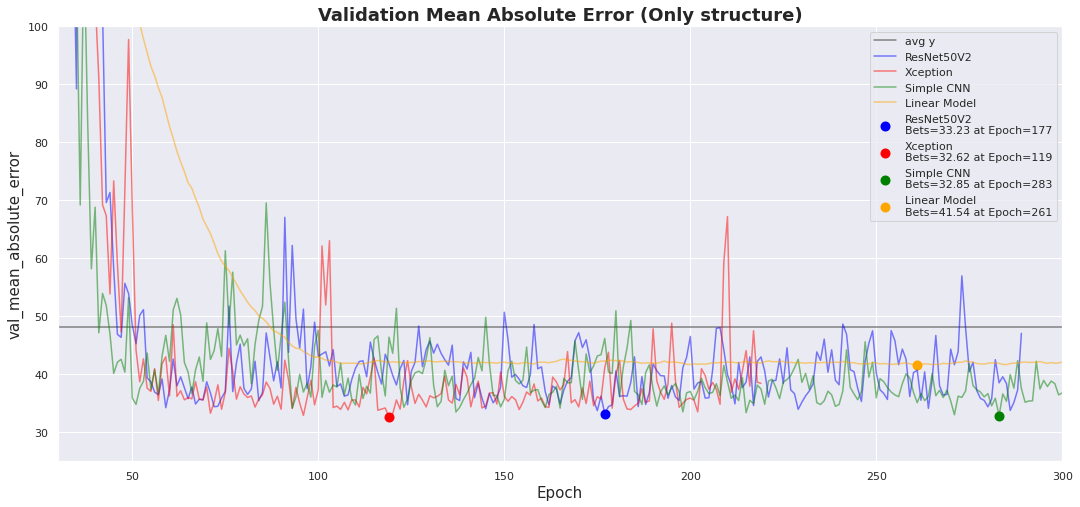

In [153]:
path = '/home/hhughes/Documents/Master_Thesis/Project/workspace/Manuscript_content/Results_data/Model_metrics'
file_names = ['history_RN_1.json', 'history_XC_1.json', 'history_BL_1.json', 'history_LM_1.json']
model_names = ['ResNet50V2', 'Xception', 'Simple CNN', 'Linear Model']
colors = ['blue', 'red', 'green', 'orange']
metric = 'val_mean_absolute_error'

# Load history
history = {}
for fn, mn in zip(file_names, model_names):
    with open(os.path.join(path, fn), 'r') as file:
        temp = json.load(file)
        history[mn] = temp[metric]

title = 'Validation Mean Absolute Error (Only structure)'
plot_train_metrics(history=history, 
                   title=title,
                   metric=metric,
                   colors=colors,
                   figsize=(18,8)
                  )

## Training plots Spatial and Color

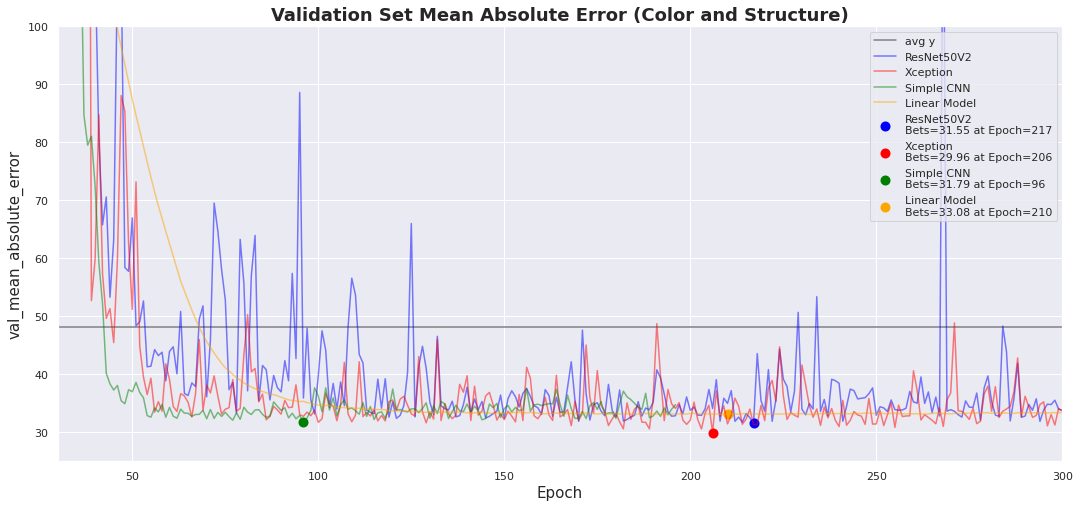

In [154]:
file_names = ['history_RN_2.json', 'history_XC_2.json', 'history_BL_2.json', 'history_LM_2.json']
model_names = ['ResNet50V2', 'Xception', 'Simple CNN', 'Linear Model']
colors = ['blue', 'red', 'green', 'orange']
metric = 'val_mean_absolute_error'

# Load history
history = {}
for fn, mn in zip(file_names, model_names):
    with open(os.path.join(path, fn), 'r') as file:
        temp = json.load(file)
        history[mn] = temp[metric]

title = 'Validation Set Mean Absolute Error (Color and Structure)'
plot_train_metrics(history=history, 
                   title=title,
                   metric=metric,
                   colors=colors,
                   figsize=(18,8),
                   ylim=[25, 100]
                  )

In [163]:
mask = metadata_df.set == 'val'
temp_df = metadata_df[~mask]

temp_df['00_EU_avg'].values

array([431.54362576, 461.47423609, 372.57073853, ..., 441.32298105,
       387.57098917, 255.99736176])

# For presentation

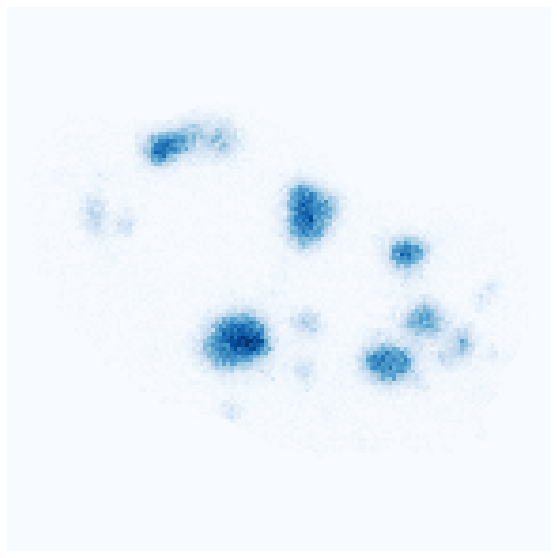

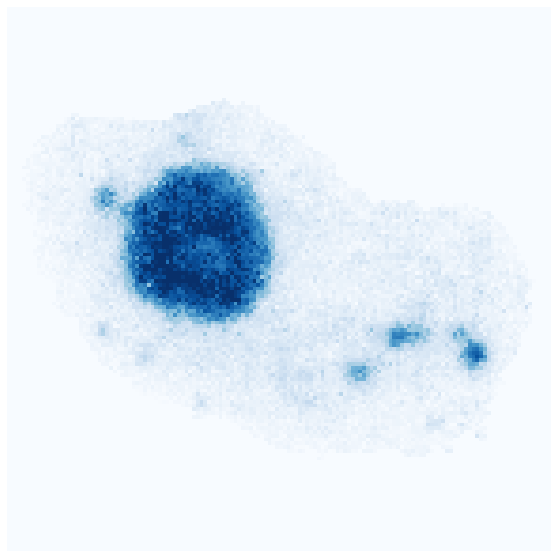

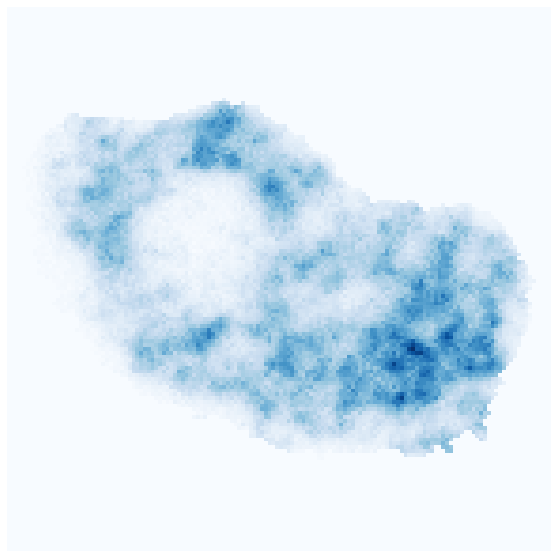

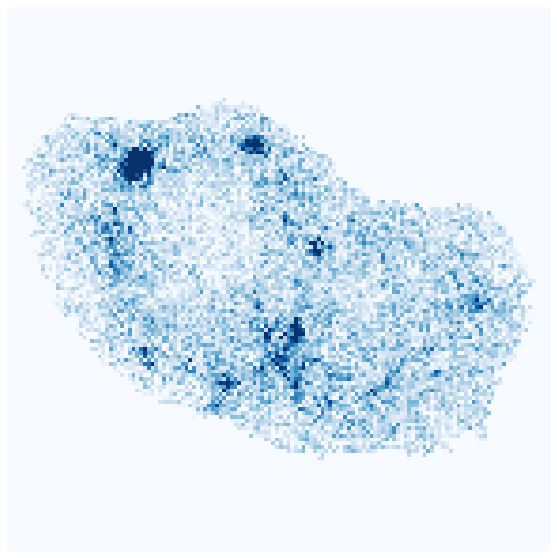

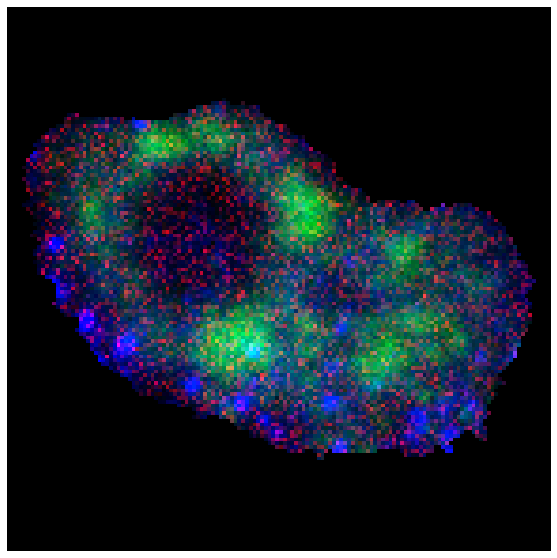

In [69]:
def plot_cell_4(img, cmap='Blues', vmin=0, vmax=1, colorbar=False, alpha=1):
    plt.imshow(img,
               cmap=getattr(plt.cm, cmap),
               vmin=vmin, vmax=vmax,
               aspect='equal',
               alpha=alpha
               )
    plt.grid(False)
    plt.axis('off')
    
test_id = '258520'
temp_img = copy.deepcopy(cells[test_id+'_img'])
temp_mask = cells[test_id+'_mask']
min_val = temp_img[temp_mask].min(axis=0)
max_val = temp_img[temp_mask].max(axis=0)
temp_img[temp_mask] = (temp_img[temp_mask] - min_val) / (max_val - min_val)
ids = [7,18,25,32]
l_idx = 40
h_idx = 184

for cid in ids:
    fig = plt.figure(figsize=(10,10))
    img = np.flip(temp_img[l_idx:h_idx,l_idx:h_idx,cid], axis=1)
    plot_cell_4(img=img)
    fig.savefig('./temp_'+str(cid)+'.jpg', bbox_inches='tight', pad_inches=0)
    
fig = plt.figure(figsize=(10,10))
ids = [10, 11, 15]
img = np.flip(temp_img[l_idx:h_idx,l_idx:h_idx,ids], axis=1)
plot_cell_4(img=img)
fig.savefig('./temp.jpg', bbox_inches='tight', pad_inches=0)

# TR correlation


In [81]:
black_list = [277420, 195486]
mask = metadata_df.mapobject_id_cell.isin(black_list)
metadata_df = metadata_df[~mask].copy()
metadata_df

mapobject_id_cell  mapobject_id plate_name well_name  well_pos_y  \
0                263042        263055    plate01       J16           0   
1                263043        263056    plate01       J16           0   
2                263044        263057    plate01       J16           0   
3                263045        263058    plate01       J16           0   
4                263047        263060    plate01       J16           0   
...                 ...           ...        ...       ...         ...   
3698             266516        266565    plate01       J12           5   
3699             266518        266567    plate01       J12           5   
3700             266519        266568    plate01       J12           5   
3701             266520        266569    plate01       J12           5   
3702             266521        266570    plate01       J12           5   

      well_pos_x  tpoint  zplane  label  is_border plate_name_cell  \
0              0       0       0      4          0         plate01   
1              0       0       0      5          0         plate01   
2              0       0       0      6          0         plate01   
3              0       0       0      7          0         plate01   
4              0       0       0      9          0         plate01   
...          ...     ...     ...    ...        ...             ...   
3698           4       0       0     44          0         plate01   
3699           4       0       0     46          0         plate01   
3700           4       0       0     47          0         plate01   
3701           4       0       0     48          0         plate01   
3702           4       0       0     49          0         plate01   

     well_name_cell  well_pos_y_cell  well_pos_x_cell  tpoint_cell  \
0               J16                0                0            0   
1               J16                0                0            0   
2               J16                0                0            0   
3               J16                0                0            0   
4               J16                0                0            0   
...             ...              ...              ...          ...   
3698            J12                5                4            0   
3699            J12                5                4            0   
3700            J12                5                4            0   
3701            J12                5                4            0   
3702            J12                5                4            0   

      zplane_cell  label_cell  is_border_cell  is_mitotic  is_mitotic_labels  \
0               0           4               0         0.0                NaN   
1               0           5               0         0.0                NaN   
2               0           6               0         0.0                NaN   
3               0           7               0         0.0                NaN   
4               0           9               0         0.0                NaN   
...           ...         ...             ...         ...                ...   
3698            0          44               0         0.0                NaN   
3699            0          46               0         0.0                NaN   
3700            0          47               0         0.0                NaN   
3701            0          48               0         0.0                NaN   
3702            0          49               0         0.0                NaN   

      is_polynuclei_HeLa  is_polynuclei_HeLa_labels  is_polynuclei_184A1  \
0                    0.0                        NaN                  0.0   
1                    0.0                        NaN                  0.0   
2                    0.0                        NaN                  0.0   
3                    0.0                        NaN                  0.0   
4                    0.0                        NaN                  0.0   
...               

In [147]:
X_columns = [n for n in metadata_df.columns if '_avg' in n]
corr_df = metadata_df[X_columns].corr(method='pearson')[['00_EU_avg']]
corr_df = corr_df.sort_values(by='00_EU_avg', ascending=False).reset_index()
corr_df.columns = ['channel', '00_EU_avg']
corr_df.head()

channel  00_EU_avg
0          00_EU_avg   1.000000
1  10_POL2RA_pS2_avg   0.525093
2  01_CDK9_pT186_avg   0.510861
3        02_CDK7_avg   0.507128
4      07_POLR2A_avg   0.480384

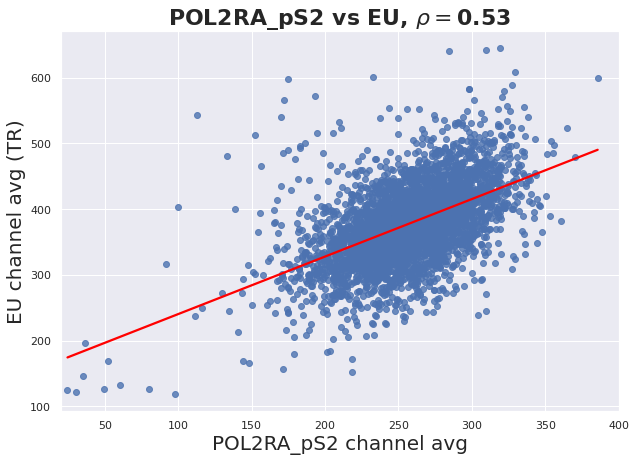

In [148]:
ch = '10_POL2RA_pS2_avg'
ch_name = 'POL2RA_pS2'
mask = corr_df['channel'] == ch
roh = corr_df[mask]['00_EU_avg'].values[0]

fig = plt.figure(figsize=(10,7))
sns.regplot(data=metadata_df,
                x=ch,
                y='00_EU_avg',
            ci=None,
            line_kws={"color": "red"}
               )
plt.ylabel('EU channel avg (TR)', fontsize=20)
plt.xlabel(ch_name+' channel avg', fontsize=20)
plt.title(ch_name + ' vs EU, '+r'$\rho=$'+str(round(roh,2)), fontweight='bold', fontsize=22)
plt.xlim([20, 400])
fig.savefig('./temp.png', bbox_inches='tight', pad_inches=0, transparent=True)

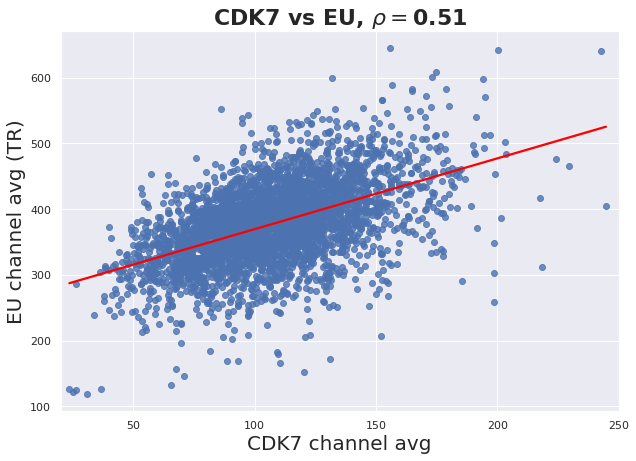

In [150]:
ch = '02_CDK7_avg'
mask = corr_df['channel'] == ch
roh = corr_df[mask]['00_EU_avg'].values[0]

fig = plt.figure(figsize=(10,7))
sns.regplot(data=metadata_df,
                x=ch,
                y='00_EU_avg',
            ci=None,
            line_kws={"color": "red"}
               )
plt.ylabel('EU channel avg (TR)', fontsize=20)
plt.xlabel('CDK7 channel avg', fontsize=20)
title = 'CDK7 vs EU, '
plt.title('CDK7 vs EU, '+r'$\rho=$'+str(round(roh,2)), fontweight='bold', fontsize=22)
plt.xlim([20, 250])
fig.savefig('./temp.png', bbox_inches='tight', pad_inches=0, transparent=True)

Opening cell: 321003, 1/9


Opening cell: 233624, 2/9


Opening cell: 324769, 3/9
Opening cell: 241664, 4/9


Opening cell: 279410, 5/9
Opening cell: 340174, 6/9


Opening cell: 266494, 7/9


Opening cell: 321016, 8/9


Opening cell: 277417, 9/9


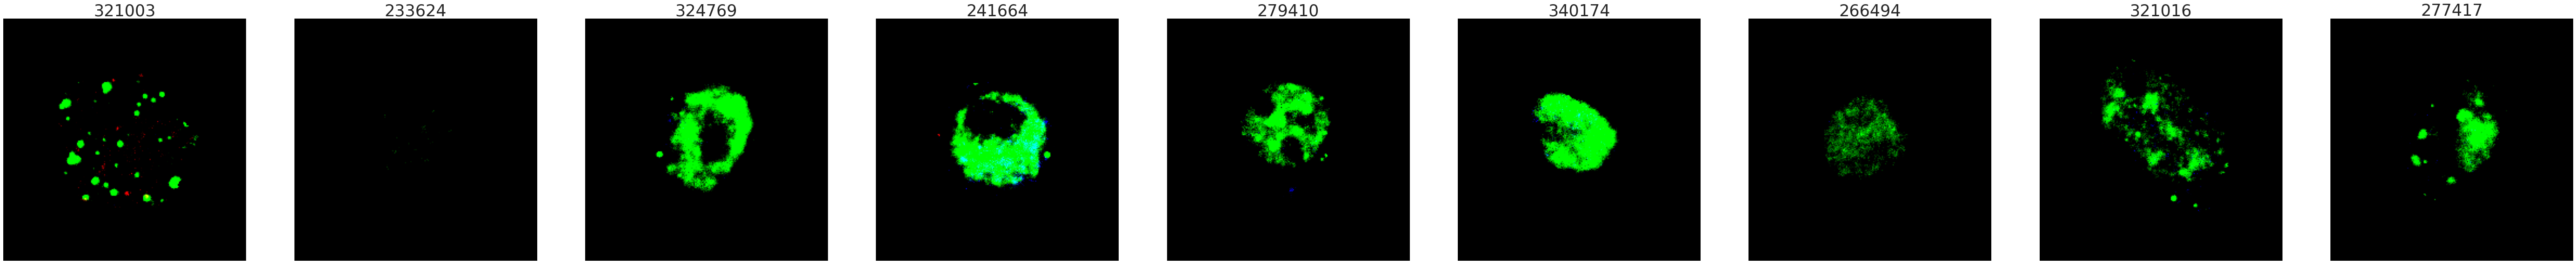

In [119]:
metadata_df['mapobject_id_cell'] = metadata_df['mapobject_id_cell'].astype(str)

mask = metadata_df['10_POL2RA_pS2_avg'] < 100
mask &= metadata_df['00_EU_avg'] < 200
cell_size_ids = metadata_df[mask].mapobject_id_cell.values

# Load cell, compute its Score map and save it
score_maps_dir = os.path.join(params['score_maps_path'], 'data')
#params['cells'] = big_cells
n_cells = len(cell_size_ids)
plt.figure(figsize=(n_cells*11,10))
dss = [train_data, val_data, test_data]
ds_names = ['train', 'val', 'test']
cell_count = 0
cells_2 = {}
for ds, dsn in zip(dss, ds_names):
    for cell in ds:
        # get cell id
        cell_id = cell['mapobject_id_cell'].numpy()
        cell_id = str(cell_id.decode())

        if cell_id in cell_size_ids:
            cell_count += 1
            print('Opening cell: {}, {}/{}'.format(cell_id, cell_count, n_cells))
            
            cells_2[cell_id+'_img'] = cell['image'][:,:,:-1].numpy()
            cells_2[cell_id+'_img'] = cells_2[cell_id+'_img'].astype(np.float32)
            
            cells_2[cell_id+'_mask'] = cell['image'].numpy()
            cells_2[cell_id+'_mask'] = cells_2[cell_id+'_mask'][:,:,-1]
            cells_2[cell_id+'_mask'] = cells_2[cell_id+'_mask'].astype(np.bool)
            
            # Plot cells
            temp_img = cells_2[cell_id+'_img'][:,:,10:13]
            plt.subplot(1, n_cells, cell_count)

            nn_inter.plot_cell(img=temp_img, title=cell_id, title_fontsize=35)

In [123]:
cells_2.keys()

dict_keys(['321003_img', '321003_mask', '233624_img', '233624_mask', '324769_img', '324769_mask', '241664_img', '241664_mask', '279410_img', '279410_mask', '340174_img', '340174_mask', '266494_img', '266494_mask', '321016_img', '321016_mask', '277417_img', '277417_mask'])

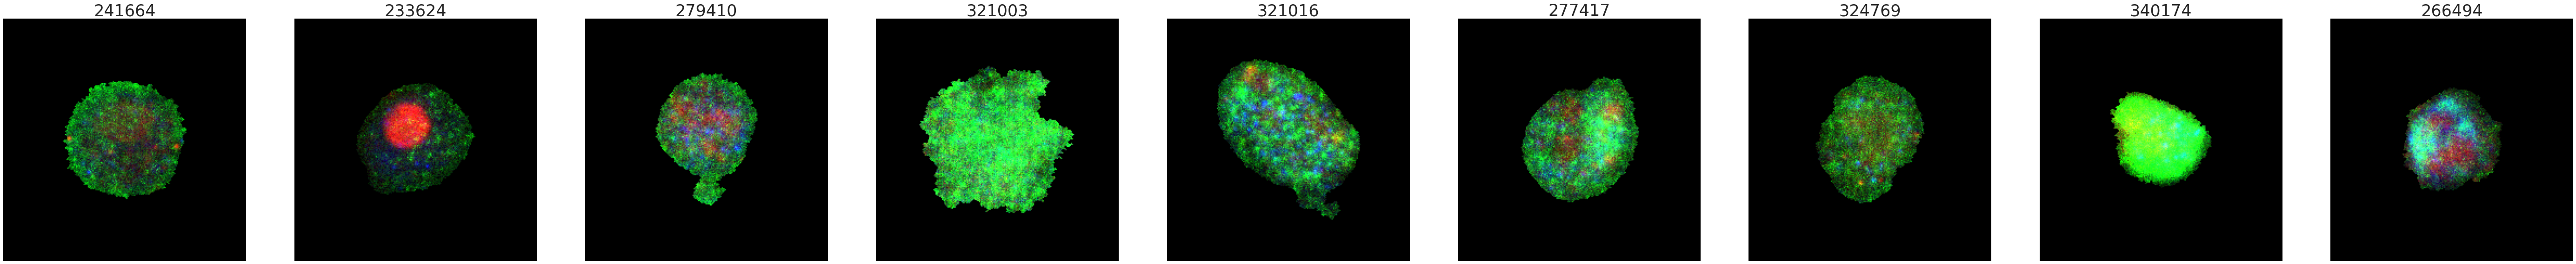

In [133]:
ids = [0,1,2]
ids = [3,4,5]
ids = [6,7,8]
ids = [9,10,11]
ids = [12,13,14]
ids = [15,16,17]
ids = [18,19,20]
n_cells = len(cell_size_ids)
plt.figure(figsize=(n_cells*11,10))

# Plot cells
for cell_count, cell_id in enumerate(cell_size_ids, 1):
    temp_img = cells_2[cell_id+'_img'][:,:,ids]
    temp_mask = cells_2[cell_id+'_mask']
    
    min_val = temp_img[temp_mask].min(axis=0)
    max_val = temp_img[temp_mask].max(axis=0)
    temp_img[temp_mask] = (temp_img[temp_mask] - min_val) / (max_val - min_val)
    
    plt.subplot(1, n_cells, cell_count)

    nn_inter.plot_cell(img=temp_img, title=cell_id, title_fontsize=35)